In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

In [2]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

print(f"Train samples:{len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

FACE_DETECTION_FOLDER = '../input/haar-cascades-for-face-detection'
print(f"Face detection resources: {os.listdir(FACE_DETECTION_FOLDER)}")

Train samples:401
Test samples: 400
Face detection resources: ['haarcascade_smile.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_fullbody.xml', 'haarcascade_upperbody.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_eye_tree_eyeglasses.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_eye.xml', 'haarcascade_profileface.xml']


In [3]:
# Check files type
train_list = list(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_list = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_list):
        ext_list.append(file_ext)
print(f"Extensions: {ext_list}")

# count how many files with each extensions there are
for file_ext in ext_list:
    print('No. of', file_ext, ':', len([file for file in train_list if file.endswith(file_ext)]))

Extensions: ['mp4', 'json']
No. of mp4 : 400
No. of json : 1


In [4]:
test_list = list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))
ext_list = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_list):
        ext_list.append(file_ext)
print(f"Extensions: {ext_list}")

for file_ext in ext_list:
    print('No. of', file_ext, ':', len([file for file in test_list if file.endswith(file_ext)]))

Extensions: ['mp4']
No. of mp4 : 400


In [5]:
json_file = [file for file in train_list if file.endswith('json')][0]
print(f"json file: {json_file}")

json file: metadata.json


In [6]:
# There is a json file(metadata.json) & we will explore this file
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    # rows and cols are diffult to see so apply transpose
    df = df.T
    return df

In [7]:
meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()
# the index has the .mp4 file names

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [8]:
# Missing data
def missing_data(data):
    total = data.isnull().sum()
    percent = (total/data.isnull().count()*100)
    tp = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tp['Types'] = types
    
    return tp

missing_data(meta_train_df)

,Total,Percent,Types
label,0,0.00,object
split,0,0.00,object
original,77,19.25,object


In [9]:
missing_data(meta_train_df.loc[meta_train_df.label=='REAL'])
# all missing original data are the one associated with REAL label
# missing_data(meta_train_df.loc[meta_train_df.label=='FAKE'])

,Total,Percent,Types
label,0,0.0,object
split,0,0.0,object
original,77,100.0,object


In [10]:
# Unique vals
def unique_values(data):
    total = data.count()
    t = pd.DataFrame(total)
    t.columns = ['Total']
    
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    t['Uniques'] = uniques
    
    return t
    
unique_values(meta_train_df)
# We observe that original label has the same pattern for uniques values. 
# We know that we have 77 missing data (that's why total is only 323) 
# and we observe that we do have 209 unique examples.

,Total,Uniques
label,400,2
split,400,1
original,323,209


In [11]:
# Most frequent originals
def most_frequent_values(data):
    total = data.count()
    t = pd.DataFrame(total)
    t.columns = ['Total']
    
    items = []
    vals = []
    for col in data.columns:
        # count unique rows -> value_counts(), taking 1st index as it's val is greater so more occurence/frequent
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    t['Most frequent item'] = items
    t['Frequence'] = vals
    t['Percent from total'] = np.round(vals / total * 100, 3)
    return t
  
most_frequent_values(meta_train_df)
# We see that most frequent label is FAKE (80.75%), 
# meawmsgiti.mp4 is the most frequent original (6 samples).

,Total,Most frequent item,Frequence,Percent from total
label,400,FAKE,323,80.750
split,400,train,400,100.000
original,323,atvmxvwyns.mp4,6,1.858


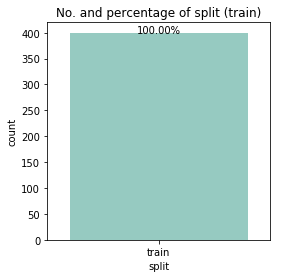

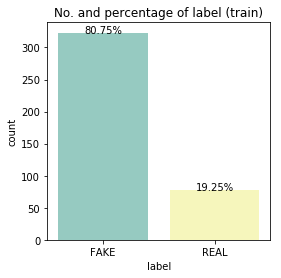

In [12]:
def plot_count(feature, title, df):
    f, ax = plt.subplots(1, 1, figsize=(4, 4))
    total = float(len(df))
    g = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("No. and percentage of {}".format(title))
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2, height, '{:1.2f}%'.format((height/total)*100), ha="center")
    plt.show()
    
plot_count('split', 'split (train)', meta_train_df)
plot_count('label', 'label (train)', meta_train_df)
# print(meta_train_df['label'].value_counts().index[:2])

In [13]:
# Video data exploration
# Missing video (or meta) data
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

Metadata: 400, Folder: 400
Files in metadata and not in folder: 0
Files in folder and not in metadata: 0


In [14]:
# Few fake videos(the index contains the .mp4 file names so .index gives the .mp4 file names)
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

['cknyxaqouy.mp4', 'dptrzdvwpg.mp4', 'eczrseixwq.mp4']

In [15]:
def display_image_from_video(video_path):
    cap_img = cv.VideoCapture(video_path)
    ret, frame = cap_img.read()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)

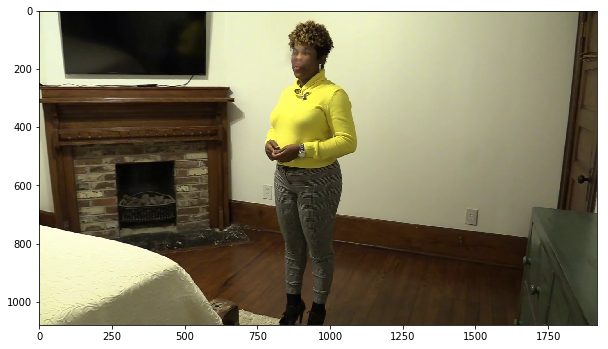

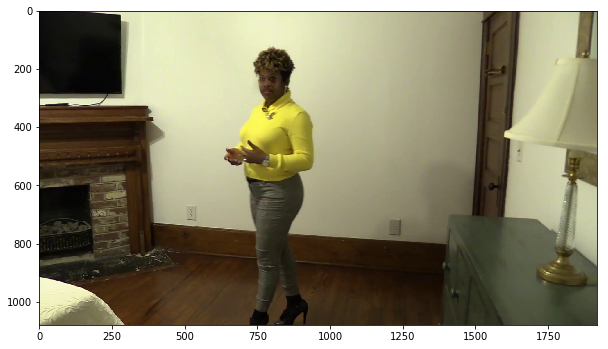

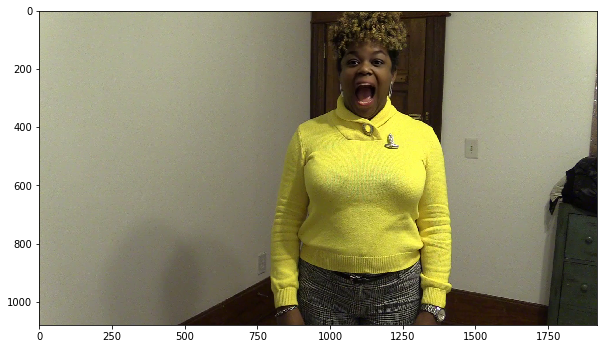

In [16]:
for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [17]:
# Few real videos
real_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='REAL'].sample(3).index)
real_train_sample_video

['ehtdtkmmli.mp4', 'axntxmycwd.mp4', 'cizlkenljw.mp4']

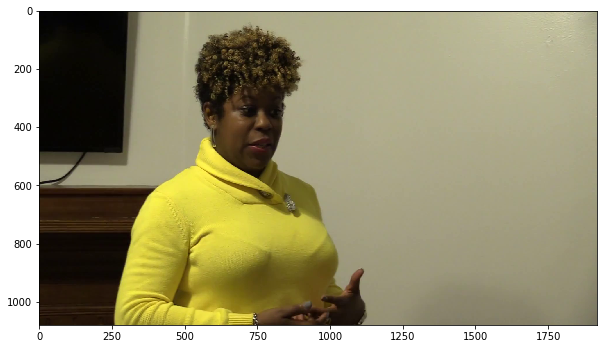

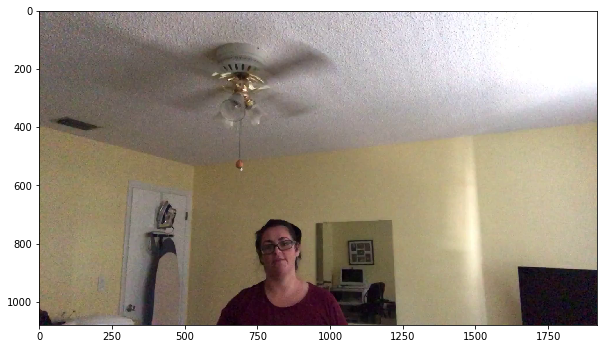

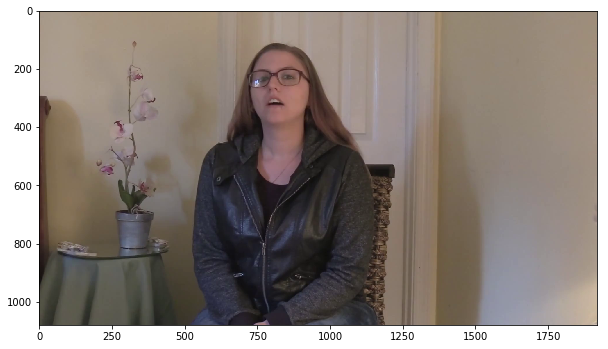

In [18]:
for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

In [19]:
# Videos with same original
meta_train_df['original'].value_counts()[0:5]

atvmxvwyns.mp4    6
meawmsgiti.mp4    6
kgbkktcjxf.mp4    5
qeumxirsme.mp4    5
gbqrgajyca.mp4    4
Name: original, dtype: int64

In [20]:
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

<Figure size 432x288 with 0 Axes>

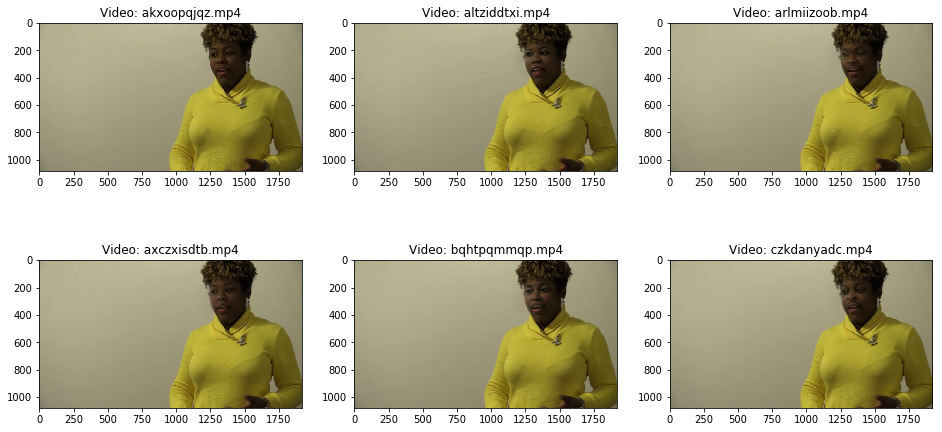

In [21]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='meawmsgiti.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

<Figure size 432x288 with 0 Axes>

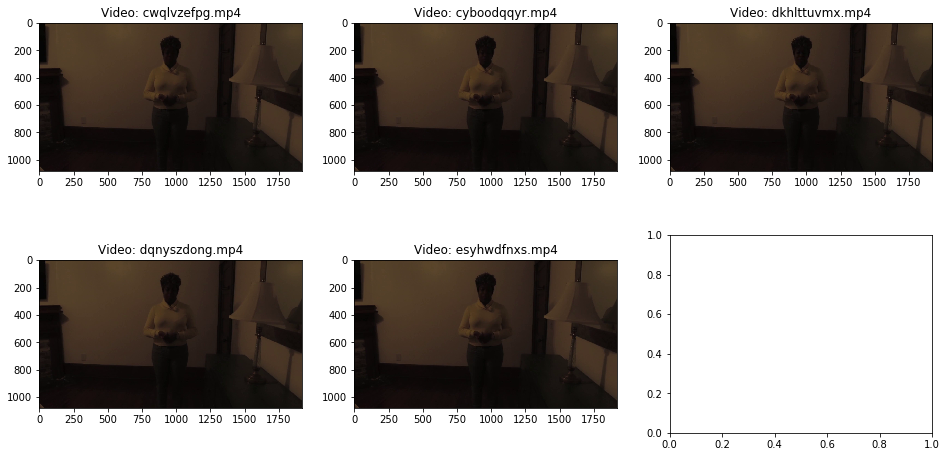

In [22]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='qeumxirsme.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

<Figure size 432x288 with 0 Axes>

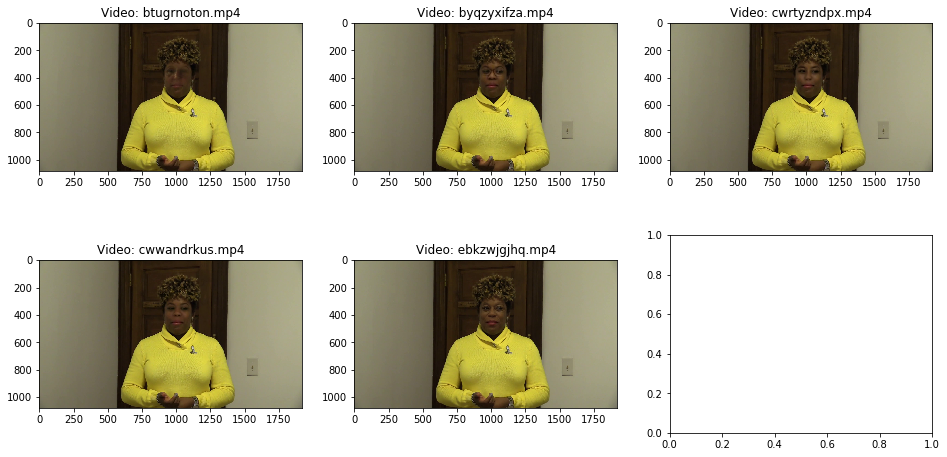

In [23]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

In [24]:
# Test video files(provide a col name, since no col name is there)
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])
test_videos.head()

,video
0,nplviymzlg.mp4
1,qlvsqdroqo.mp4
2,yhylappzid.mp4
3,elackxuccp.mp4
4,csnkohqxdv.mp4


<Figure size 432x288 with 0 Axes>

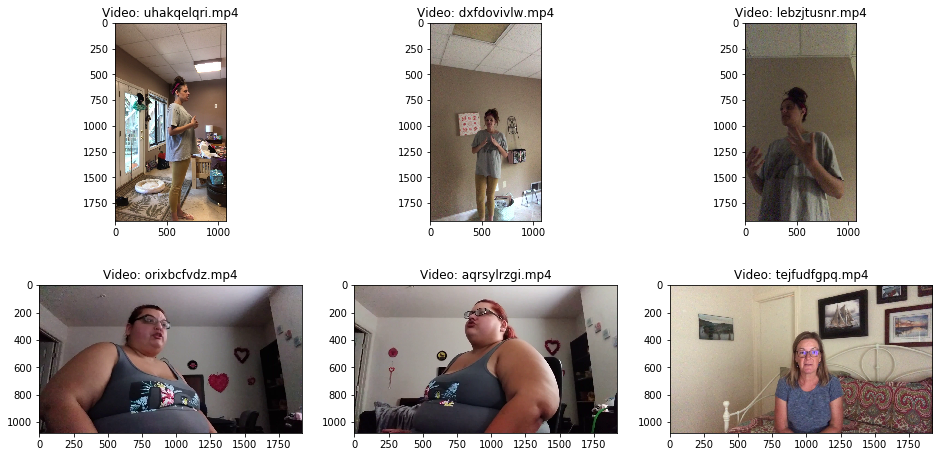

In [25]:
# show one of test
display_image_from_video_list(test_videos.sample(6).video, TEST_FOLDER)

In [26]:
# Face detection
class ObjectDetector():
    
    def __init__(self, object_cascade_path):
        self.objectCascade = cv.CascadeClassifier(object_cascade_path)
        
    def detect(self, image, scale_factor=1.3, min_neighbors=5, min_size=(20, 20)):
        rects = self.objectCascade.detectMultiScale(image, 
                                                    scaleFactor=scale_factor,
                                                    minNeighbors=min_neighbors,
                                                    minSize=min_size)
        return rects

In [27]:
frontal_cascade_path = os.path.join(FACE_DETECTION_FOLDER, 'haarcascade_frontalface_default.xml')
eye_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_eye.xml')
profile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_profileface.xml')
smile_cascade_path= os.path.join(FACE_DETECTION_FOLDER,'haarcascade_smile.xml')

fd = ObjectDetector(frontal_cascade_path)
ed = ObjectDetector(eye_cascade_path)
pd = ObjectDetector(profile_cascade_path)
sd = ObjectDetector(smile_cascade_path)

In [28]:
def detect_objects(image, scale_factor, min_neighbors, min_size):
    
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    eyes = ed.detect(image_gray, scale_factor=scale_factor, min_neighbors=min_neighbors, min_size=(int(min_size[0]/2), int(min_size[1]/2)))
    
    for x, y, w, h in eyes:
        cv.circle(image, (int(x+w/2), int(y+h/2)), (int((w + h)/4)), (0, 0, 255), 3)
    
    profiles = pd.detect(image_gray, scale_factor=scale_factor, min_neighbors=min_neighbors, min_size=min_size)
    
    for x, y, w, h in profiles:
        cv.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 3)
    
    faces = fd.detect(image_gray, scale_factor=scale_factor, min_neighbors=min_neighbors, min_size=min_size)

    for x, y, w, h in faces:
        cv.rectangle(image,(x, y),(x+w, y+h),(0, 255, 0), 3)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ax.imshow(image)

In [29]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    
    video_path = os.path.join(DATA_FOLDER, video_set_folder, video_file)
    cap_image = cv.VideoCapture(video_path)
    ret, frame = cap_image.read()
    
    detect_objects(image=frame, scale_factor=1.3, min_neighbors=5, min_size=(50, 50))

byqzyxifza.mp4
cwrtyzndpx.mp4
cwwandrkus.mp4


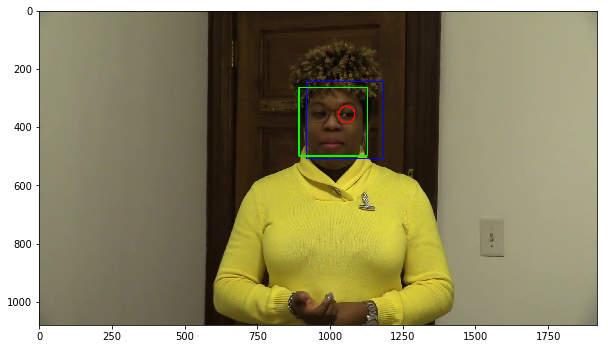

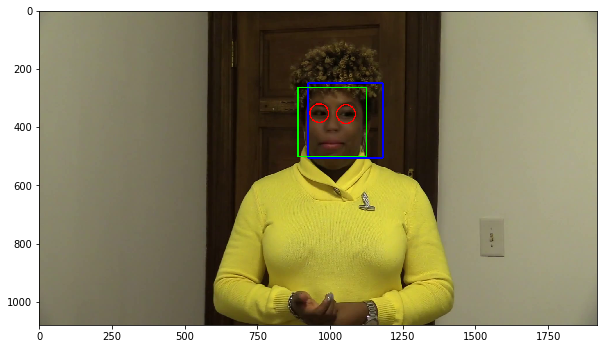

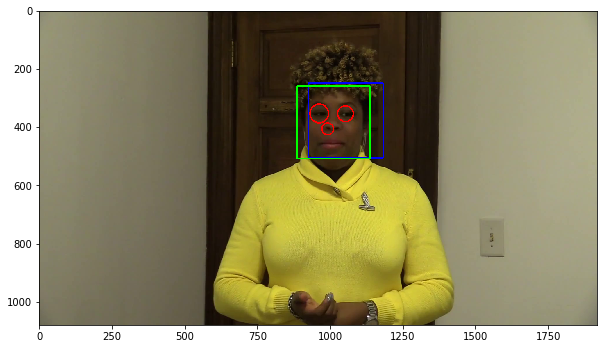

In [30]:
same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
for video_file in same_original_fake_train_sample_video[1:4]:
    print(video_file)
    extract_image_objects(video_file)

In [31]:
fake_videos = list(meta_train_df.loc[meta_train_df.label == 'FAKE'].index)

In [32]:
from IPython.display import HTML
from base64 import b64encode

def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    video_url = open(os.path.join(DATA_FOLDER, subset, video_file),'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(video_url).decode()
    return HTML("""<video width=500 controls><source src="%s" type="video/mp4"></video>""" % data_url)

In [34]:
play_video(fake_videos[0])

TypeError: join() argument must be str or bytes, not 'list'